In [1]:
import os
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception

2025-09-26 00:17:08.665022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758845828.907559      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758845828.971225      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# plot sample of data

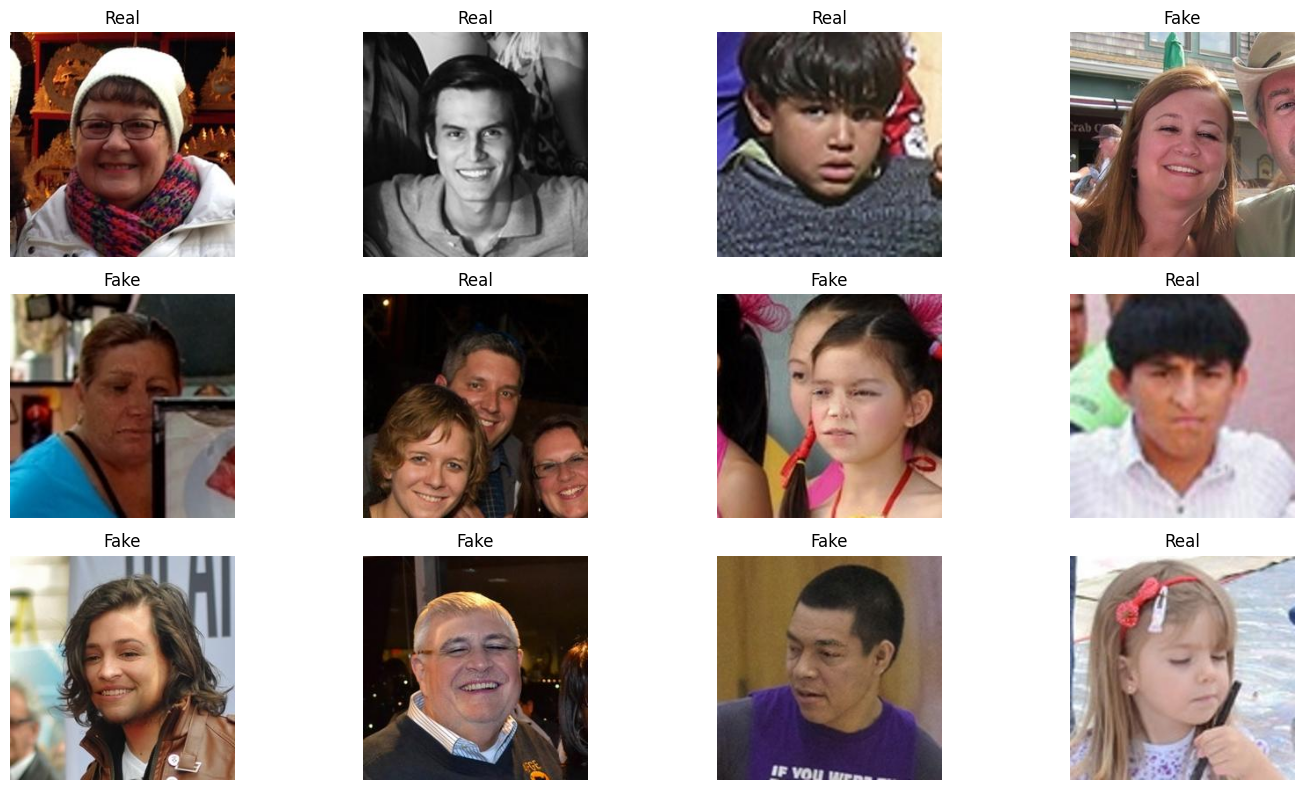

In [3]:
fake_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train/Fake"
real_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train/Real"

fake_images = random.sample(os.listdir(fake_dir), 6)
real_images = random.sample(os.listdir(real_dir), 6)

all_images = [(os.path.join(fake_dir, f), "Fake") for f in fake_images] + \
             [(os.path.join(real_dir, r), "Real") for r in real_images]

random.shuffle(all_images)

plt.figure(figsize=(15, 8))
for i, (img_path, label) in enumerate(all_images):
    plt.subplot(3, 4, i+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [2]:
train_data_gen = ImageDataGenerator(
    rescale = 1./255 ,
    rotation_range=20,        
    width_shift_range=0.2,    
    height_shift_range=0.2,  
    shear_range=0.15,         
    zoom_range=0.2,           
    horizontal_flip=True,     
    brightness_range=[0.8,1.2], 
    fill_mode="nearest"   
    
)
data_gen = ImageDataGenerator( rescale = 1./255 )

TARGET_SIZE = (256,256)
train_generator = train_data_gen.flow_from_directory(
    directory = "/kaggle/input/deepfake-and-real-images/Dataset/Train",
    class_mode = 'binary',
    target_size = TARGET_SIZE,
    batch_size = 32,
)

val_generator = data_gen.flow_from_directory(
    directory = "/kaggle/input/deepfake-and-real-images/Dataset/Validation",
    class_mode = 'binary',
    target_size = TARGET_SIZE,
    batch_size = 32,
    shuffle = False
)

test_generator = data_gen.flow_from_directory(
    directory = "/kaggle/input/deepfake-and-real-images/Dataset/Test",
    class_mode = 'binary',
    target_size = TARGET_SIZE,
    batch_size = 32,
    shuffle = False
)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


# XceptionNet Model 

In [9]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

I0000 00:00:1758555287.210077      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Callbacks

In [10]:
model_checkpoint = ModelCheckpoint(
    'XceptionNet_best_model.h5',
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_accuracy',restore_best_weights=True, patience=5)
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.3,
    min_lr=1e-7
)

In [11]:
model.compile(optimizer = Adam(learning_rate=1e-4),
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

### Training

In [12]:
history = model.fit(train_generator, epochs = 10, validation_data = val_generator , 
                    callbacks = [model_checkpoint, early_stopping, lr_reduction] )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1758555359.888057     123 service.cc:148] XLA service 0x7b93bc006dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758555359.888881     123 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758555363.556872     123 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1758555374.928361     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758555375.153301     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758555376.095851     123 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758555376.3289

4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.9373 - loss: 0.1533
Epoch 1: val_accuracy improved from -inf to 0.96908, saving model to XceptionNet_best_model.h5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 3546s 795ms/step - accuracy: 0.9373 - loss: 0.1533 - val_accuracy: 0.9691 - val_loss: 0.0818 - learning_rate: 1.0000e-04
Epoch 2/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9806 - loss: 0.0506
Epoch 2: val_accuracy improved from 0.96908 to 0.97489, saving model to XceptionNet_best_model.h5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 2778s 635ms/step - accuracy: 0.9806 - loss: 0.0506 - val_accuracy: 0.9749 - val_loss: 0.0722 - learning_rate: 1.0000e-04
Epoch 3/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9851 - loss: 0.0399
Epoch 3: val_accuracy improved from 0.97489 to 0.98088, saving model to XceptionNet_best_model.h5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 2817s 644ms/step - accuracy: 0.9851 - loss: 0.0399 - val_accuracy: 0.9809 - val_loss: 0.0533 - learning_rate: 1.000

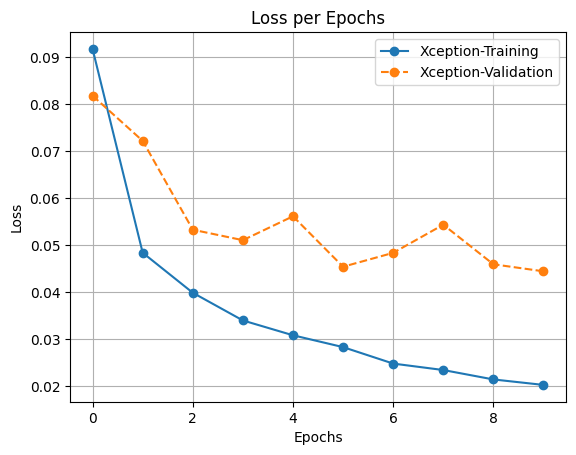

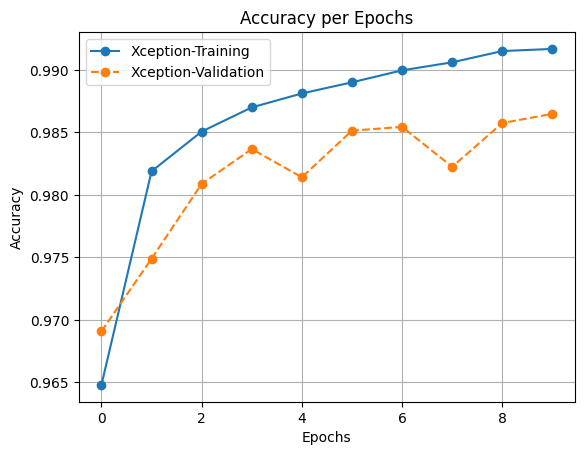

In [16]:
plt.plot(history.history['loss'], label='Xception-Training', marker='o')
plt.plot(history.history['val_loss'], label='Xception-Validation',linestyle='--', marker='o')
plt.title('Loss per Epochs') 
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history['accuracy'], label='Xception-Training', marker='o')
plt.plot(history.history['val_accuracy'], label='Xception-Validation',linestyle='--', marker='o')
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [3]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/xceptionnet/tensorflow2/default/1/XceptionNet_best_model.h5")

loss, accuracy = model.evaluate(test_generator)

I0000 00:00:1758846081.487094      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1758846088.628197     118 service.cc:148] XLA service 0x7986b043cdc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758846088.629280     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758846089.144978     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/341 ━━━━━━━━━━━━━━━━━━━━ 30s 89ms/step - accuracy: 0.9688 - loss: 0.0599

I0000 00:00:1758846094.207450     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


341/341 ━━━━━━━━━━━━━━━━━━━━ 96s 256ms/step - accuracy: 0.9481 - loss: 0.3604


341/341 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step


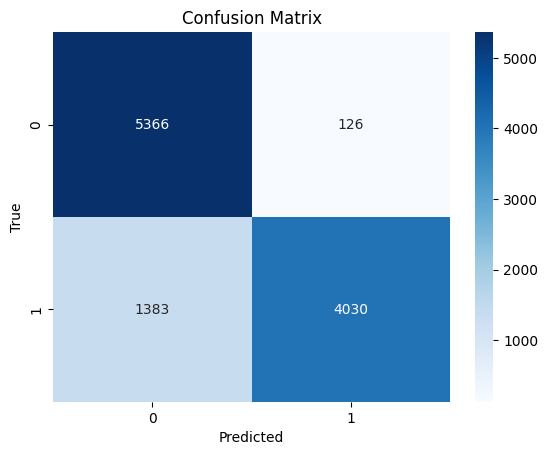

              precision    recall  f1-score   support

        Fake       0.80      0.98      0.88      5492
        Real       0.97      0.74      0.84      5413

    accuracy                           0.86     10905
   macro avg       0.88      0.86      0.86     10905
weighted avg       0.88      0.86      0.86     10905



In [17]:
y_true = test_generator.classes

y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names = test_generator.class_indices.keys()))

341/341 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step


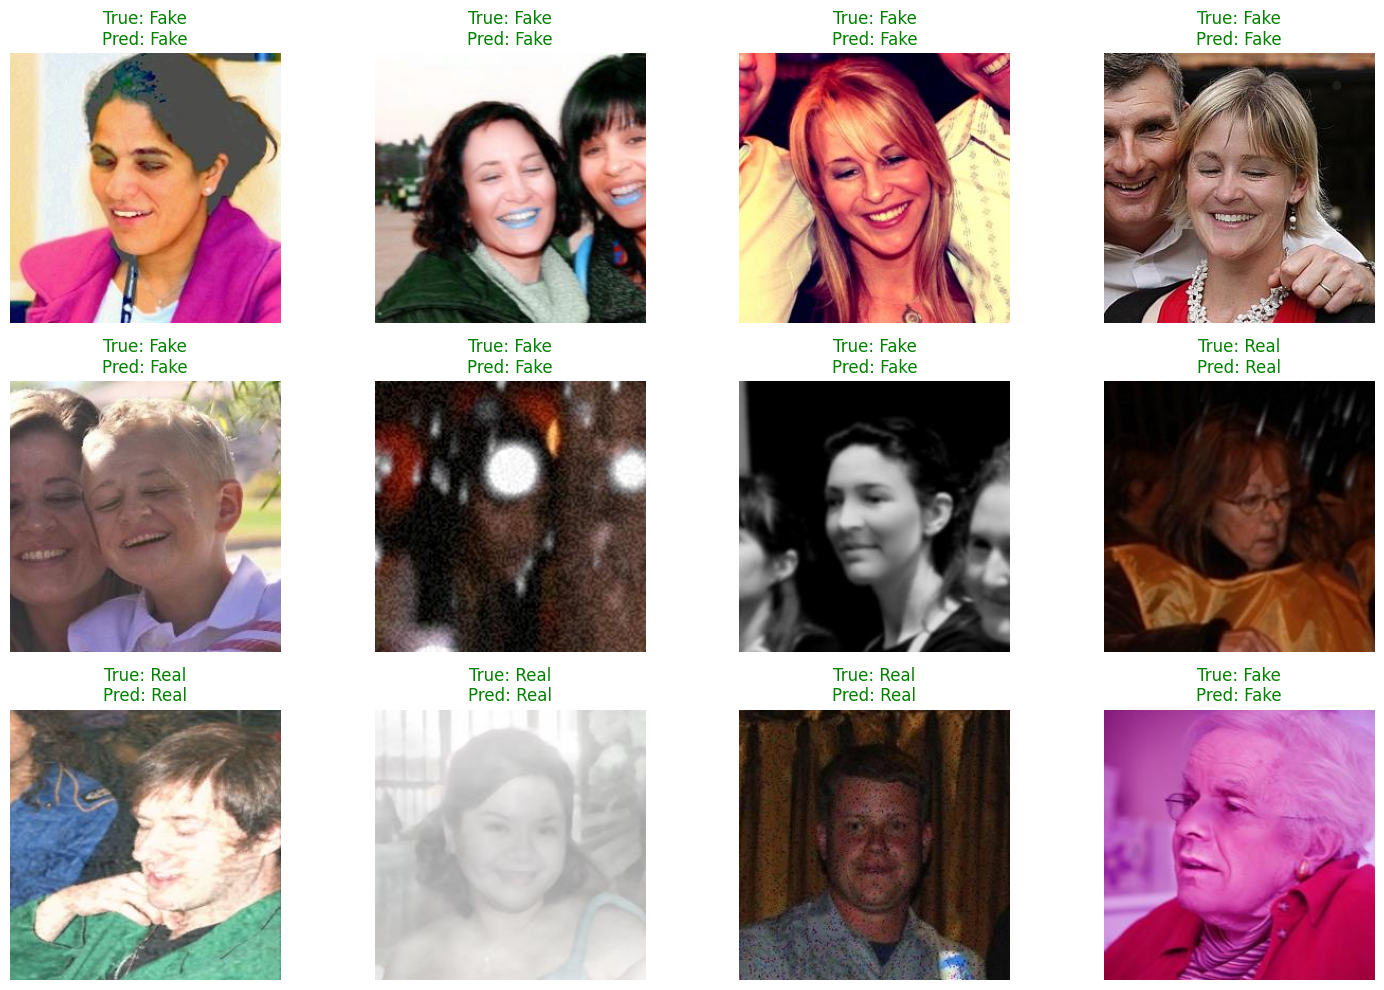

In [19]:
test_generator.reset()    # Reset generator so predictions align with labels

y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

class_names = list(test_generator.class_indices.keys())

indices = np.random.choice(len(y_true), size=12, replace=False)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    img_path = test_generator.filepaths[idx]  
    img = plt.imread(img_path)

    plt.subplot(3, 4, i+1)
    plt.imshow(img.astype("uint8"))
    
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()